# Képmanipuláció

In [ ]:
!pip install mediapipe --quiet     # can take a minute

!wget http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/ea8_imi_img/glasses.png
!wget http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/ea8_imi_img/library.png
!wget http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/ea8_imi_img/student.png

In [ ]:
!curl --output selfie_multiclass_256x256.tflite https://storage.googleapis.com/mediapipe-models/image_segmenter/selfie_multiclass_256x256/float32/latest/selfie_multiclass_256x256.tflite
!curl --output ssd_mobilenet_v2.tflite https://storage.googleapis.com/mediapipe-models/object_detector/ssd_mobilenet_v2/float16/latest/ssd_mobilenet_v2.tflite
!curl --output blaze_face_short_range.tflite https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite

## Titkos mikkentyűk

In [ ]:
import numpy as np
import skimage as ski
import mediapipe as mp
import matplotlib.pyplot as plt

In [ ]:
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


def segment(image):
    base_options = python.BaseOptions(model_asset_path='selfie_multiclass_256x256.tflite')
    options = vision.ImageSegmenterOptions(base_options=base_options, output_category_mask=True)

    with vision.ImageSegmenter.create_from_options(options) as segmenter:
        img = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
        result = segmenter.segment(img)
        return result.confidence_masks[0].numpy_view()


def detect(image):
    base_options = python.BaseOptions(model_asset_path='ssd_mobilenet_v2.tflite')
    options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5, max_results=1)

    with vision.ObjectDetector.create_from_options(options) as detector:
        img = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
        result = detector.detect(img)
        return result.detections[0].bounding_box, result.detections[0].categories[0].category_name


def face_detection(image):
    base_options = python.BaseOptions(model_asset_path='blaze_face_short_range.tflite')
    options = vision.FaceDetectorOptions(base_options=base_options, running_mode=vision.RunningMode.IMAGE, min_suppression_threshold=0.8)

    with vision.FaceDetector.create_from_options(options) as detector:
        img = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
        result = detector.detect(img)
        return result.detections[0].bounding_box


# 1. Képek betöltése

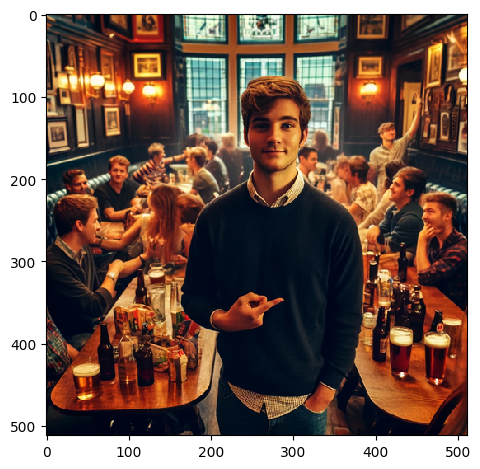

In [ ]:
student = ski.io.imread('./student.png')
ski.io.imshow(student)

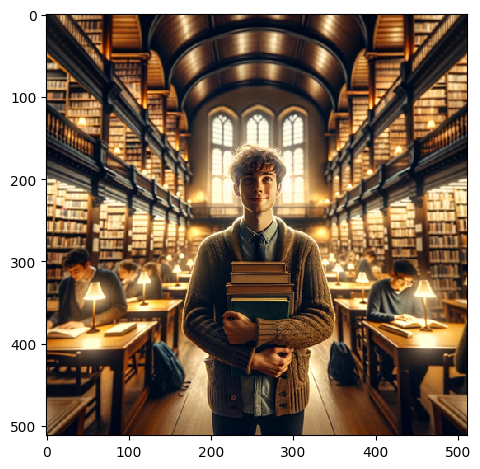

In [ ]:
library = ski.io.imread('./library.png')
ski.io.imshow(library)

# 2. A hallgató szegmentálása

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


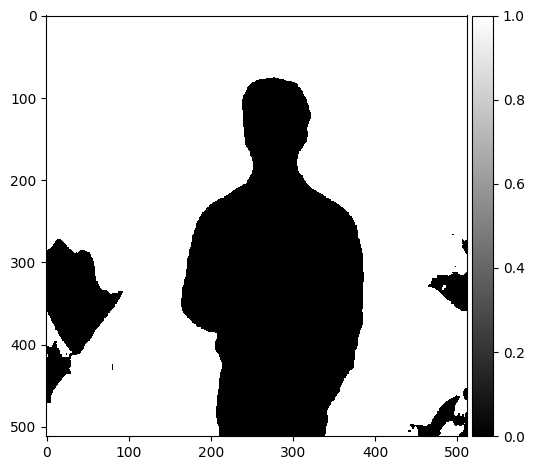

In [ ]:
mask = segment(student)
mask = mask.copy()
mask[mask > 0.5] = 1
mask = mask.astype(np.uint8)

ski.io.imshow(mask, cmap='gray')

# 3. Zaj csökkentése:

# 3.1 Először vágjuk ki a hallgatót és utána szegmentáljuk

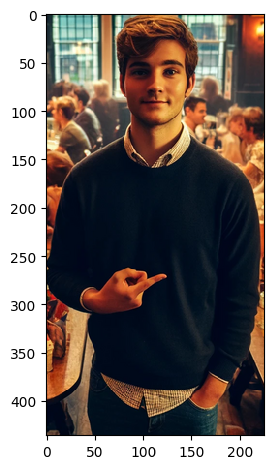

In [ ]:
bbox, _ = detect(student)
x, y, w, h = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
cut = student[y:y+h, x:x+w]
ski.io.imshow(cut)

# 3.2 Szegmentáljuk a hallgatót

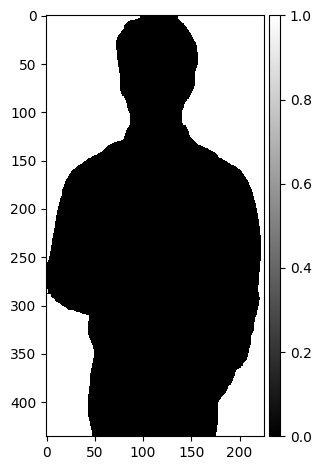

In [ ]:
mask = segment(cut.copy())
mask = mask.copy()
mask[mask > 0.5] = 1
mask = mask.astype(np.uint8)

ski.io.imshow(mask, cmap='gray')

# 3.3 A mask segítségével vágjuk ki a hallgatót

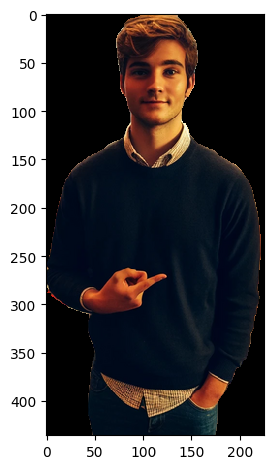

In [ ]:
segmented = cut.copy()

mask = mask.astype(bool)
mask = mask[:,:,None]
mask_b = np.concatenate((mask, mask, mask), 2)
segmented[mask_b] = 0

ski.io.imshow(segmented)

# 4. Hely előkészítése a kivágott hallgató számára

# 4.1 Másik hallgató detektálása

(159, 163, 196, 351) person


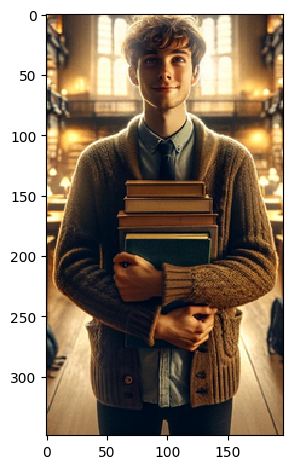

In [ ]:
bbox, cls = detect(library)

x, y, w, h = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
print((x, y, w, h), cls)

lib = library[y:y+h, x:x+w]

ski.io.imshow(lib)

# 4.2 Az előző hallgató bounding boxának megfelelő slice készítése

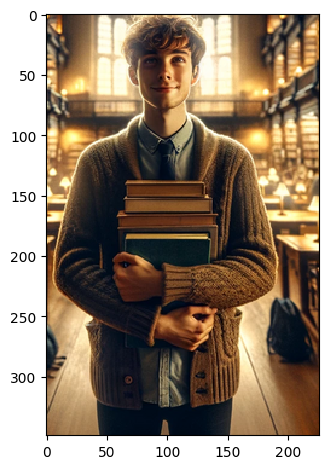

In [ ]:
library_c = library.copy()
slc = library[y:y+mask.shape[0], x:x+mask.shape[1]]
ski.io.imshow(slc)

# 4.3 A slice középre igazítása

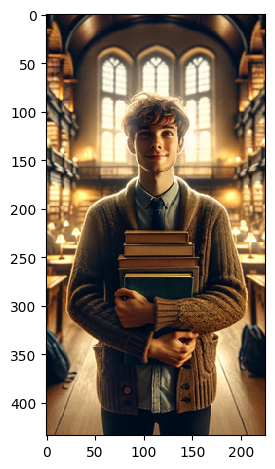

In [ ]:
library_c = library.copy()

x_offset = (mask_b.shape[1] - w)//2
y_offset = (mask_b.shape[0] - h)

m_h, m_w, m_c = mask_b.shape

slc = library_c[y-y_offset:y-y_offset+m_h, x-x_offset:x-x_offset+m_w]

ski.io.imshow(slc)

# 4.4 A bounding box megigazítása

In [ ]:
print(y + h)
print(library.shape)

514
(512, 512, 3)


In [ ]:
overflow = y + h - library.shape[1]
print(overflow)

2


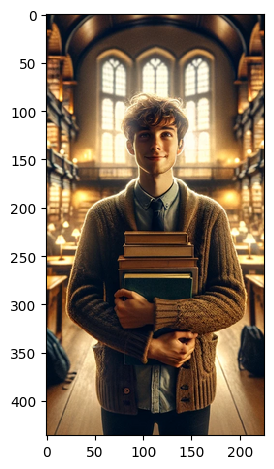

In [ ]:
library_c = library.copy()

Y = y-y_offset-overflow
Y_ = y-y_offset-overflow+mask.shape[0]
X = x-x_offset
X_ = x-x_offset+mask.shape[1]

slc = library_c[Y:Y_, X:X_]
ski.io.imshow(slc)

# 4.5 Nézzük meg, hogy ki fogjuk-e takarni a másik hallgatót

(436, 226, 1)


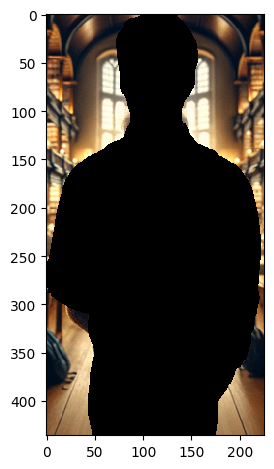

In [ ]:
print(mask.shape)

slc[~mask_b] = 0
ski.io.imshow(slc)

# 5. Hallgató beillesztése

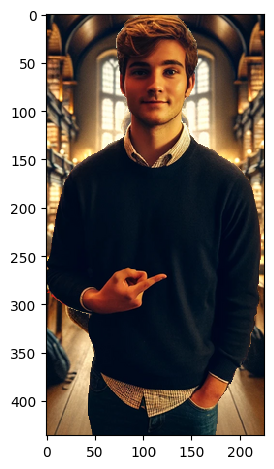

In [ ]:
slc[~mask_b] = segmented[~mask_b]
ski.io.imshow(slc)

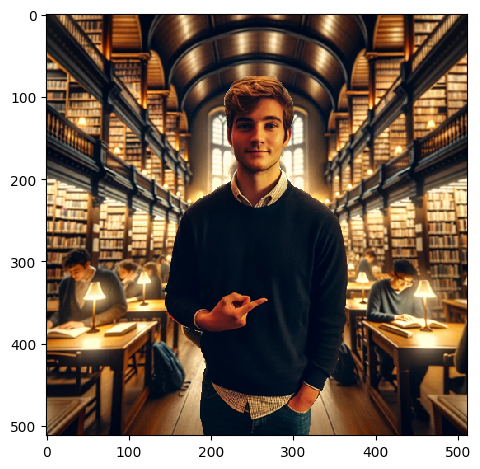

In [ ]:
ski.io.imshow(library_c)

# 6. Tüntessük el az éles éleket

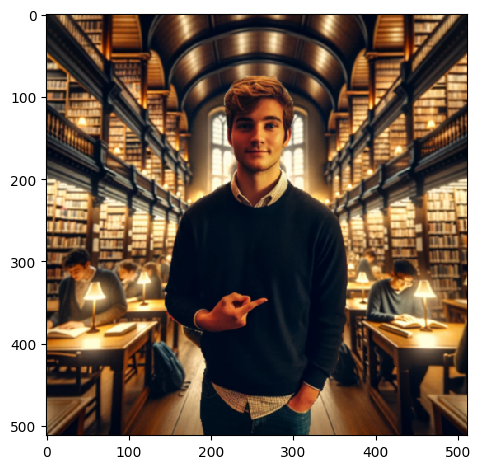

In [ ]:
smoothed = ski.filters.gaussian(library_c, sigma=0.6, channel_axis=2)

ski.io.imshow(smoothed)

# 7. Tegyük rá az alfa csatornával rendelkező képet a hallgatóra

# 7.1 Olvassuk be a képet

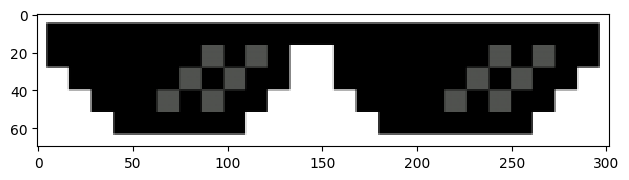

In [ ]:
glasses = ski.io.imread('./glasses.png')
ski.io.imshow(glasses)

# 7.2 Detektáljuk a hallgató arcát

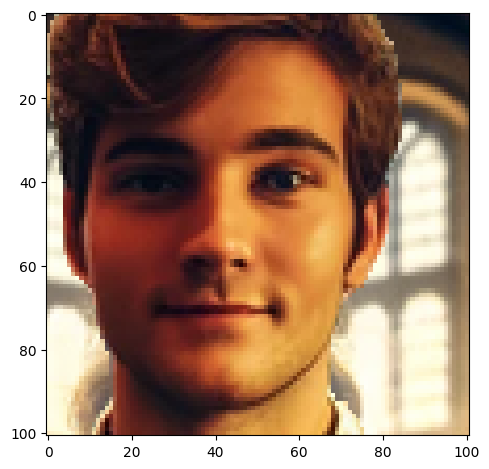

In [ ]:
face_bbox = face_detection(library_c.copy())
x, y, w, h = face_bbox.origin_x, face_bbox.origin_y, face_bbox.width, face_bbox.height
ski.io.imshow(library_c[y:y+h, x:x+w])

# 7.3 Méretezzük át a szemüveget a bounding box méretére

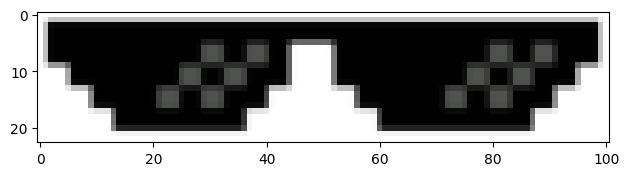

In [ ]:
aspect_ratio = glasses.shape[0] / glasses.shape[1]
glasses_small = ski.transform.resize(glasses, (w*aspect_ratio, w))
ski.io.imshow(glasses_small)

# 7.4 Adjunk alpha chatornát az eredeti képhez

In [ ]:
alpha = np.ones((library_c.shape[0], library_c.shape[1], 1)).astype(np.uint8) * 255
libr = np.concatenate((library_c.copy(), alpha), axis=2)

# 7.5 Rakjuk rá a szemüveget a képre

In [ ]:
offset_x = 7
offset_y = 30

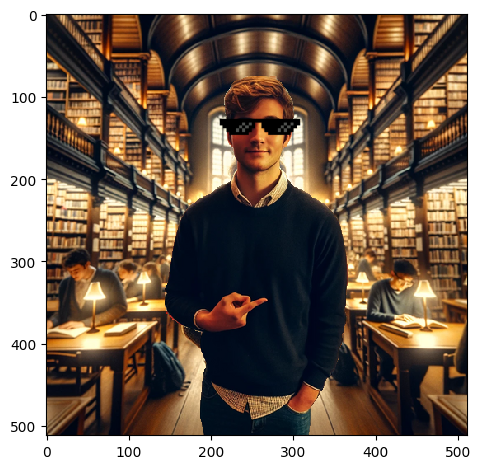

In [ ]:
result = (libr.copy() / 255).astype(np.float64)

alpha = glasses_small[:,:,3].copy()

h, w, c = glasses_small.shape

res = result[y+offset_y:y+offset_y+h, x-offset_x:x-offset_x+w]

lib_colors = (1 - alpha[:,:,None]) * res[:,:,:3]
glasses_colors = alpha[:,:,None] * glasses_small[:,:,:3]

res[:,:,:3] = lib_colors + glasses_colors

ski.io.imshow(result)